In [6]:
%matplotlib inline
import torch
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
tcd = torch.distributions
torch.set_default_dtype(torch.float64) #without it we have underflow and we can encounter problems
sns.set_theme()

# Data

<AxesSubplot:>

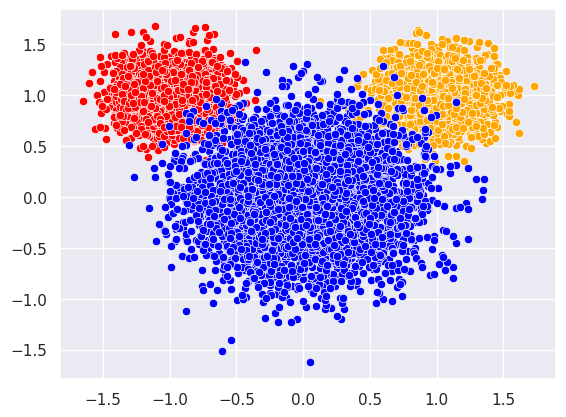

In [9]:
var_ear=0.2**2
var_head=0.4**2
left_ear = tcd.MultivariateNormal(torch.tensor([-1,1]).double(),var_ear*torch.eye(2))
right_ear = tcd.MultivariateNormal(torch.tensor([1,1]).double(),var_ear*torch.eye(2))
head= tcd.MultivariateNormal(torch.tensor([0,0]).double(),var_head*torch.eye(2))
N=10000
p=0.5
a = left_ear.sample(torch.Size([int(N*(1-p)/2)]))
b = right_ear.sample(torch.Size([int(N*(1-p)/2)]))
c = head.sample(torch.Size([int(N*p)]))
data = torch.cat((a, b, c))
sns.scatterplot(x=a[:,0],y=a[:,1],color="red")
sns.scatterplot(x=b[:,0],y=b[:,1],color="orange")
sns.scatterplot(x=c[:,0],y=c[:,1],color="blue")

# Initialization

In [10]:
def initialize(n):
    mu = torch.rand([n, 2]) * 4 - 2
    sigma = torch.rand([n, 2, 2])
    sigma = torch.matmul(sigma, torch.transpose(sigma, 1, 2))+torch.eye(2)*0.0001
    pi = torch.rand(n)
    pi = pi / torch.sum(pi)
    return sigma, mu, pi

# Expectation

In [11]:
def expectation_GMM(n,pi,mu,sigma,data):
    dis = []
    for i in range(n):
        dis.append(tcd.MultivariateNormal(loc=mu[i],covariance_matrix=sigma[i]))
    wyn = torch.zeros(len(data),n)
    for i in range(n):
        wyn[:,i]=dis[i].log_prob(data)+torch.log(pi[i])
    wyn = torch.exp(wyn)
    for i in range(len(data)):
        wyn[i,:]=wyn[i,:]/torch.sum(wyn[i,:])
    return wyn

In [12]:
sigma, mu, pi = initialize(3)
print(pi)
print(mu)
print(sigma)

tensor([0.0993, 0.4119, 0.4889])
tensor([[ 1.3812, -1.0006],
        [ 1.9526, -0.6473],
        [-0.8796, -1.5666]])
tensor([[[1.1267, 0.8080],
         [0.8080, 0.6279]],

        [[1.0520, 0.9876],
         [0.9876, 1.0157]],

        [[0.0542, 0.1407],
         [0.1407, 0.4886]]])


# Maximalization

In [13]:
def maximalization(likelihood, data,min_var=1e-3,eps=1e-3):
    suma=torch.sum(likelihood,axis=0)
    pi = suma/len(data)
    mu = (torch.matmul(data.T,likelihood) / suma).T
    sigma=(torch.einsum("ij,ia,ib->jab",likelihood,data,data)+torch.einsum("ij,ja,jb->jab",likelihood,mu,mu)+
    (torch.einsum("ij,ia,jb->jab",likelihood,-data,mu)+torch.einsum("ij,ja,ib->jab",likelihood,-mu,data)))
    for j in range(len(pi)):
        sigma[j]/=(suma[j]+eps)
    sigma=torch.clamp(sigma, min=min_var)
    return pi,mu,sigma

In [14]:
for u in range(1000):
    soft_reg=expectation_GMM(3,pi,mu,sigma,data)
    pi,mu,sigma=maximalization(soft_reg,data)

In [15]:
print(pi)
print(mu)
print(sigma)

tensor([0.5008, 0.2499, 0.2493])
tensor([[ 0.0022,  0.0049],
        [ 0.9994,  1.0015],
        [-1.0002,  0.9913]])
tensor([[[0.1567, 0.0010],
         [0.0010, 0.1603]],

        [[0.0403, 0.0010],
         [0.0010, 0.0379]],

        [[0.0395, 0.0010],
         [0.0010, 0.0387]]])


# Clasification

In [16]:
def classy(wyn,data):
    ind=torch.argmax(wyn, axis=1)
    return ind

<AxesSubplot:>

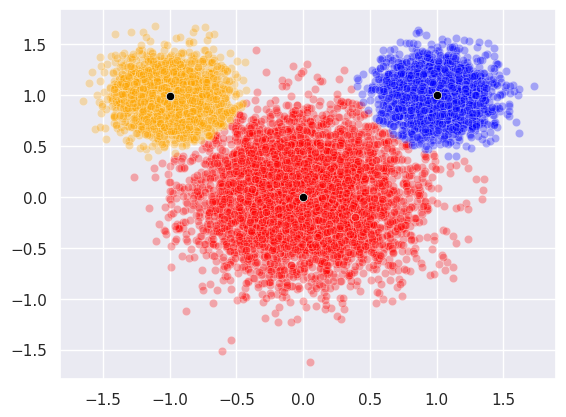

In [17]:
pred_EM=classy(soft_reg,data)
first=data[pred_EM==0]
sec=data[pred_EM==1]
third=data[pred_EM==2]
sns.scatterplot(x=first[:,0],y=first[:,1],color="red",alpha=0.3)
sns.scatterplot(x=sec[:,0],y=sec[:,1],color="blue",alpha=0.3)
sns.scatterplot(x=third[:,0],y=third[:,1],color="orange",alpha=0.3)
sns.scatterplot(x=mu[:,0],y=mu[:,1],color="black")

In [18]:
kmeans=KMeans(3,random_state=0).fit(data)

<AxesSubplot:>

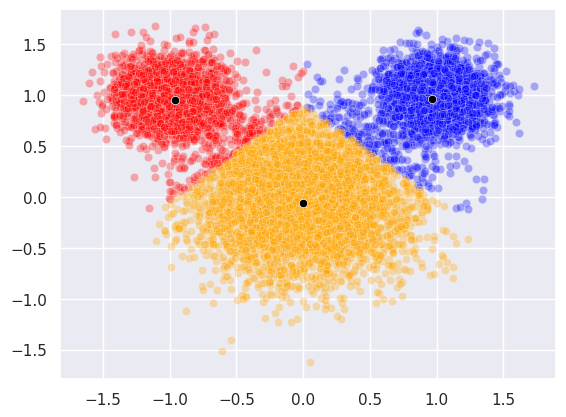

In [19]:
pred_KM=kmeans.predict(data)
first_KM=data[pred_KM==0]
sec_KM=data[pred_KM==1]
third_KM=data[pred_KM==2]
sns.scatterplot(x=first_KM[:,0],y=first_KM[:,1],color="red",alpha=0.3)
sns.scatterplot(x=sec_KM[:,0],y=sec_KM[:,1],color="blue",alpha=0.3)
sns.scatterplot(x=third_KM[:,0],y=third_KM[:,1],color="orange",alpha=0.3)
sns.scatterplot(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black")